# You have csv files provided in the folder that you can use if you are stuck and can't get it through code on your own but if you use it since it's a big hint you will have a point deduction

# Part 1: Correlation of Future Orientation Index and Gross Domestic Product
## Tasks

In this exercise, we try to reproduce the findings of the article “Quantifying the Advantage of Looking Forward” http://www.nature.com/articles/srep00350.

According to the study, the GDP per capita of countries is positively correlated to how much their population searches in Google for the next year, relative to how much they search for the previous year.

This ratio is called the Future Orientation Index (FOI). So for example for the year 2017 the FOI can be calculated as: FOI = number of searches for the term “2018” / number of searches for the term “2016”.

You will do the following tasks:
1. Aquire World Bank Data
2. Calculate the Future Orientation Index in Google Trends
3. Test the correlation between GDP and FOI

### Install requirements. 

The following cell contains all the necessary dependencies needed for this task. If you run the cell everything will be installed.  
* [`wbgapi`](https://github.com/tgherzog/wbgapi) is a Python package which provides modern, pythonic access to the World Bank's data API. [Here](https://github.com/tgherzog/wbgapi) is the documentation of `wbgapi`.
* [`pandas`](https://pandas.pydata.org/docs/index.html) is a Python package for creating and working with tabular data. [Here](https://pandas.pydata.org/docs/reference/index.html) is the documentation of `pandas`.
* [`matplotlib`](https://matplotlib.org/) is a Python package for creating plots. [Here](https://matplotlib.org/stable/api/index.html) is the documentation of `matplotlib`.
* [`scipy`](https://scipy.org/) is a Python package with different algorithms for scientific computing. [Here](https://docs.scipy.org/doc/scipy/reference/index.html#scipy-api) is the documentation of `scipy`.

In [ ]:
! pip install wbgapi
! pip install pandas
! pip install matplotlib
! pip install scipy

### Import requirements
The cell below imports all necessary dependancies. Make sure they are installed (see cell above).

In [ ]:
import wbgapi as wb
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# 1 World Bank Data
## 1.1 Download WDI data

From the WDI we need three indicators:
* Gross Domestic Product (GDP) per capita corrected by the Purchase Power Parity (PPP in current or 2005 international $, `"NY.GDP.PCAP.PP.KD"`)
* The amount of Internet users (per 100 people, `"IT.NET.USER.ZS"`
* The total population (described as as "Population, Total", `"SP.POP.TOTL"`)

In the following code chunk, download all data (including extras) for all countries in year 2014 and save it as a pandas data frame. See [here](https://github.com/tgherzog/wbgapi#accessing-data) how to use the `data` subpackage of `wbgapi`.

Hint: To remove aggregates (economic regions defined by the World Bank) and include only countries, use `skipAggs=True`.

In [ ]:
# Your Code goes here!
WDIdf = wb.data.DataFrame(['NY.GDP.PCAP.PP.KD', 'SP.POP.TOTL', 'IT.NET.USER.ZS'],
             labels = True,time=2014, skipAggs=True)

WDIdf

,Country,IT.NET.USER.ZS,NY.GDP.PCAP.PP.KD,SP.POP.TOTL
economy,,,,
ZWE,Zimbabwe,16.4,3352.381349,14207359.0
ZMB,Zambia,6.5,3585.577485,15895315.0
YEM,"Yemen, Rep.",22.6,NaN,30226309.0
PSE,West Bank and Gaza,53.7,5990.426615,4173398.0
VIR,Virgin Islands (U.S.),50.1,42853.898660,107882.0
...,...,...,...,...
AND,Andorra,86.1,59929.244467,73737.0
ASM,American Samoa,NaN,NaN,53466.0
DZA,Algeria,29.5,15073.762940,39205031.0


Now drop any row that has `NaN` for this you can use `pandas` [`dropna`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html) method.

In [ ]:
def dropna(df, column):
    return df.dropna(subset=[column])

Next only keep rows where there are at least 5 Million internet users. Keep in Mind that the Internet Users are per 100 people, so don't forget to take the population into account.

For example in the dataset Austria has 80.995825 internet users per 100 people, while 8546356 people living in Austria. This means Austria has 6922191.55 internet users in total. The calculation for that is as follows:
$
\begin{align}
internet\_users = population \cdot \frac{internet\_user\_per\_100}{100}
\end{align}
$


In [ ]:
# Your Code goes here!
WDIdf['total_internet_users'] = WDIdf['SP.POP.TOTL'] * WDIdf['IT.NET.USER.ZS'] / 100
WDIdf_filtered = WDIdf[WDIdf['total_internet_users'] >= 5_000_000]
WDIdf_filtered

,Country,IT.NET.USER.ZS,NY.GDP.PCAP.PP.KD,SP.POP.TOTL,total_internet_users
economy,,,,,
YEM,"Yemen, Rep.",22.6,NaN,30226309.0,6.831146e+06
VNM,Viet Nam,41.0,8751.882806,91679578.0,3.758863e+07
VEN,"Venezuela, RB",57.0,NaN,30254079.0,1.724483e+07
UZB,Uzbekistan,35.5,7145.109807,30222994.0,1.072916e+07
USA,United States,73.0,63018.803393,319257560.0,2.330580e+08
...,...,...,...,...,...
AUT,Austria,81.0,60919.840708,8546356.0,6.922548e+06
AUS,Australia,84.0,55288.115338,23475686.0,1.971958e+07
ARG,Argentina,64.7,28200.815257,43024071.0,2.783657e+07


# 2 The Future Orientation Index in Google Trends
## 2.1 Download data from Google Trends

You can download the data from Google Trends following these steps:

1) Log out from your google account or set its language to English

2) Go to trends.google.com and search for 2013 

3) Add 2015 as a search term

4) Select custom time rage: full year: 2014

5) Set the region to “Worldwide”. You can also try with this link (it links to the google trends page with all settings from above applied): https://trends.google.com/trends/explore?date=2014-01-01%202014-12-31&q=2013,2015

6) Go to the map at “Compared breakdown by region” and tick on “include low search volume regions”

7) On the top right menu click the download button to get a geoMap.csv file

If you have problems getting the file from the web interface, we also included it in the github repository.

Load the .csv file in a pandas data frame. Notice in the file the first 3 Lines are actually only information (while the third is the header). You can skip these lines by using `skiprows=3` in `pd.read_csv`. Set the headers to `"Country", "G2013", "G2015"`, this can be done by the keyword argument `names` in `pd.read_csv`.

Now remove again all rows containing `NaN`.

All the percentage data is saved as a string containing the `%` symbol. You can remove this with `pandas` [`str.replace`](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.replace.html) method and save them as integer with `pandas` [`astype`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.astype.html) method. Do this for column `G2013` and `G2015`.


In [ ]:
# Your Code goes here!
gt_df = pd.read_csv('geoMap.csv', skiprows=3, names=["Country", "G2013", "G2015"])

# Remove rows with NaN values
gt_df = gt_df.dropna()

# Remove '%' and convert to integer for G2013 and G2015 columns
gt_df["G2013"] = gt_df["G2013"].str.replace('%', '').astype(int)
gt_df["G2015"] = gt_df["G2015"].str.replace('%', '').astype(int)

gt_df

,Country,G2013,G2015
0,Algeria,66,34
1,Moldova,87,13
2,Armenia,86,14
3,Pakistan,85,15
5,Kazakhstan,82,18
...,...,...,...
229,South Korea,70,30
230,Malawi,62,38
231,Taiwan,61,39
232,South Sudan,66,34


## 2.2 Calculate the Future Orientation Index

In the following code chunk, make a new column in the Google Trends dataframe with the Future Orientation Index, which is the ratio between the search volume for 2015 and 2013 in 2014 for each country

In [ ]:
# Your Code goes here!
gt_df["FOI"] = gt_df["G2015"] / gt_df["G2013"]
gt_df


,Country,G2013,G2015,FOI
0,Algeria,66,34,0.515152
1,Moldova,87,13,0.149425
2,Armenia,86,14,0.162791
3,Pakistan,85,15,0.176471
5,Kazakhstan,82,18,0.219512
...,...,...,...,...
229,South Korea,70,30,0.428571
230,Malawi,62,38,0.612903
231,Taiwan,61,39,0.639344
232,South Sudan,66,34,0.515152


## 2.3 Merge with World Bank data

Merge the WDI and google trends data frames, using the name of the country. For this you can use `pandas` [`merge`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html) method.

In [ ]:
# Your Code goes here!
merged_df = pd.merge(WDIdf_filtered, gt_df, on='Country')
merged_df

,Country,IT.NET.USER.ZS,NY.GDP.PCAP.PP.KD,SP.POP.TOTL,total_internet_users,G2013,G2015,FOI
0,Uzbekistan,35.5,7145.109807,3.022299e+07,1.072916e+07,73,27,0.369863
1,United States,73.0,63018.803393,3.192576e+08,2.330580e+08,58,42,0.724138
2,United Kingdom,91.6,49250.559990,6.462000e+07,5.919192e+07,54,46,0.851852
3,United Arab Emirates,90.4,69409.037041,8.059440e+06,7.285734e+06,68,32,0.470588
4,Ukraine,46.2,16978.812500,4.597238e+07,2.123924e+07,78,22,0.282051
5,Tunisia,46.2,12823.988807,1.127429e+07,5.208721e+06,73,27,0.369863
6,Thailand,34.9,18324.614467,7.021637e+07,2.450551e+07,72,28,0.388889
7,Switzerland,83.6,76189.601844,8.188649e+06,6.845711e+06,52,48,0.923077
8,Sweden,92.5,57085.385356,9.696110e+06,8.968902e+06,61,39,0.639344
9,Spain,76.2,41339.411117,4.646073e+07,3.540308e+07,62,38,0.612903


# 3 Testing the correlation between GDP and FOI
# 3.1 Visualize FOI vs GDP

Now that you have the FOI index, GPD per capita and PPP value for each country, you can make a scatter plot of FOI vs GDP.

For this you can use the [`scatter`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) method of `matplotlib`.

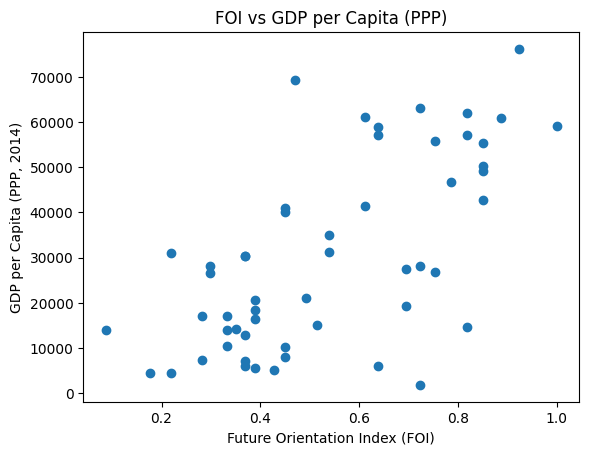

In [ ]:
# Your Code goes here!
plt.scatter(merged_df['FOI'], merged_df['NY.GDP.PCAP.PP.KD'])
plt.xlabel('Future Orientation Index (FOI)')
plt.ylabel('GDP per Capita (PPP, 2014)')
plt.title('FOI vs GDP per Capita (PPP)')
plt.show()

## 3.2 Measure Pearson’s correlation

In the following chunk, calculate Pearson’s correlation coefficient between GDP and FOI.

For this you can use the [`pearsonr`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html) method of `scipy`.

In [ ]:
# Your Code goes here!
corr, p_value = stats.pearsonr(merged_df['NY.GDP.PCAP.PP.KD'], merged_df['FOI'])
print(f"Pearson correlation coefficient: {corr:.4f}, p-value: {p_value:.4g}")

Pearson correlation coefficient: 0.6521, p-value: 9.192e-08


## 3.3 Measure correlation after shuffling

What happens if we permute the data (e.g. shuffle the FOIs) and repeat the above analysis? Do you find any difference between the two plots and two Pearson’s correlation coefficients?

For the shuffeling you can use `pandas` [`sample`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html) method with `frac` set to 1.

This test shows you if the correlation is happend by random.

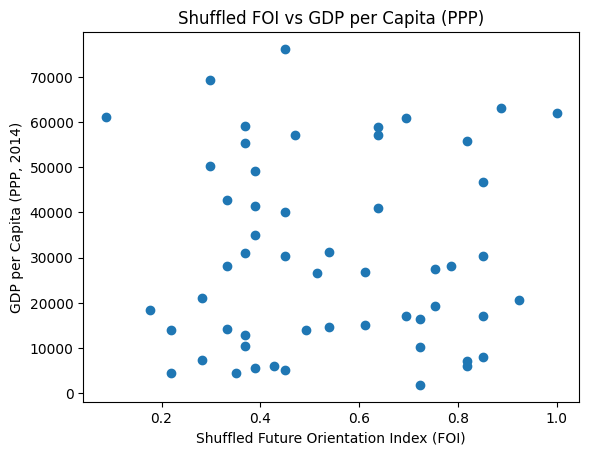

Shuffled Pearson correlation coefficient: 0.0062, p-value: 0.9646


In [ ]:
# Your Code goes here!

# Shuffle the FOI values
shuffled_foi = merged_df['FOI'].sample(frac=1, random_state=42).reset_index(drop=True)

# Scatter plot of shuffled FOI vs GDP
plt.scatter(shuffled_foi, merged_df['NY.GDP.PCAP.PP.KD'])
plt.xlabel('Shuffled Future Orientation Index (FOI)')
plt.ylabel('GDP per Capita (PPP, 2014)')
plt.title('Shuffled FOI vs GDP per Capita (PPP)')
plt.show()

# Calculate Pearson correlation for shuffled data
shuffled_corr, shuffled_p_value = stats.pearsonr(merged_df['NY.GDP.PCAP.PP.KD'], shuffled_foi)
print(f"Shuffled Pearson correlation coefficient: {shuffled_corr:.4f}, p-value: {shuffled_p_value:.4g}")

Repeat the calculation with 1000 permutations and plot the histogram of the resulting values. Add a line with the value of the correlation without permutation. Is it far or close to the permuted values?

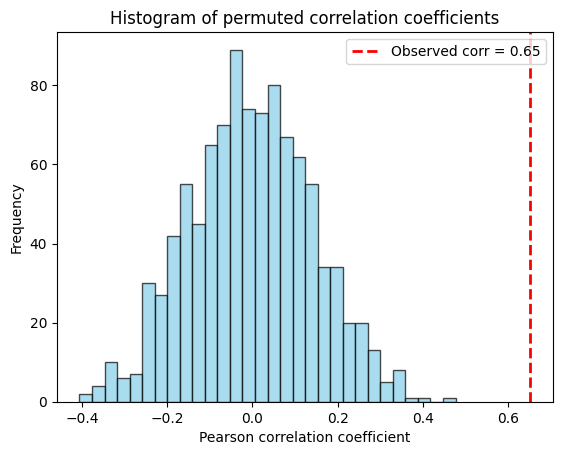

In [ ]:
# Your Code goes here!

# Perform 1000 permutations and store the correlation coefficients
n_permutations = 1000
permuted_corrs = []

for _ in range(n_permutations):
    shuffled = merged_df['FOI'].sample(frac=1, replace=False).reset_index(drop=True)
    corr_perm, _ = stats.pearsonr(merged_df['NY.GDP.PCAP.PP.KD'], shuffled)
    permuted_corrs.append(corr_perm)

# Plot histogram of permuted correlations
plt.hist(permuted_corrs, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(corr, color='red', linestyle='dashed', linewidth=2, label=f'Observed corr = {corr:.2f}')
plt.xlabel('Pearson correlation coefficient')
plt.ylabel('Frequency')
plt.title('Histogram of permuted correlation coefficients')
plt.legend()
plt.show()

# To learn more
### Check robustness
* What result do you get if you use other years? What if you choose one of the earliest years in Google trends?
* How do results change if you use a different threshod instead of 5 Million Internet users?
    
### Test other hypotheses
* Is future orientation generating wealth? Or is wealth enabling to look more to the future?
* Is the FOI really measuring orientation to the future? Could it be something else?

# Part 2: Using Google Trends data to model Flu Trends

## Tasks

Use the [pytrends module](https://pypi.org/project/pytrends/) to get weekly Google Trends data concerning the Flu/Influenza virus from the beginning of 2014 until the end of 2018.

***Hint:*** *the pytrends module currently has a bug. If you get a `TooManyRequestsError` despite following the documentation, try following the advice outlined [here](https://github.com/GeneralMills/pytrends/issues/573#issuecomment-1501897119) or [here](https://github.com/GeneralMills/pytrends/issues/561#issuecomment-1462899426) (both solve the issue).*

### Install requirements. 

The following cell contains all the necessary dependencies needed for this task. If you run the cell everything will be installed.  
* [`pytrends`]((https://pypi.org/project/pytrends/)
* [`requests`]
* [`statsmodels`]

In [ ]:
! pip install -U pytrends
! pip install requests
! pip install statsmodels

# 1 Google Trends data

## 1.1 Get weekly Google Trends data concerning the Flu/Influenza virus

- Create an instance of the `TrendReq` class
- Find the appropriate query term (i.e., influenza). The TrendReq class includes a method `suggestions`, which should help you in this task (the query term can look like e.g. `/m/03x_m3v`).
- Specify the correct geographical region, the timeframe (i.e. from the beginning of 2014 until the end of 2018), and the key-word list. Use the `build_payload` method to store this information for future requests.
- Use the `interest_over_time` method to get the data.


In [ ]:
# Your Code goes here!
from pytrends.request import TrendReq


# Create an instance of TrendReq
pytrends = TrendReq()

# Find the appropriate query term for 'influenza'
suggestions = pytrends.suggestions(keyword='influenza')
print(suggestions)  # Inspect to find the best topic id

# Let's assume we use the topic id for 'Influenza'
kw_list = ['ID_Influenza']

# Build the payload for the US, weekly data from 2014-01-01 to 2018-12-31
pytrends.build_payload(kw_list=kw_list, timeframe='2014-01-01 2018-12-31', geo='US')

# Get the interest over time data
flu_trends = pytrends.interest_over_time()
flu_trends.head()

[{'mid': '/m/0cycc', 'title': 'Influenza', 'type': 'Disease'}, {'mid': '/m/0292d3', 'title': 'Avian influenza', 'type': 'Disease'}, {'mid': '/m/057c6k', 'title': 'Swine influenza', 'type': 'Infection'}, {'mid': '/m/0416v7', 'title': 'Influenza vaccine', 'type': 'Vaccine'}, {'mid': '/g/11h_4kjr2m', 'title': 'The Book You Wish Your Parents Had Read: (And Your Children Will Be Glad That You Did)', 'type': 'Book by Philippa Perry'}]


,ID_Influenza,isPartial
date,,
2013-12-29,0,False
2014-01-05,0,False
2014-01-12,0,False
2014-01-19,0,False
2014-01-26,0,False


# 2 US National data

## Get data regarding the occurance of Influenza like Illnesses in the US

In the `Excercise 1` folder you will find a file named `ILINet.csv`, which contains data regarding the occurance of Influenza like Illnesses in the US. You can also find the data and the corresponding [documentation](https://gis.cdc.gov/grasp/fluview/FluViewPhase2QuickReferenceGuide.pdf) on the CDC's [FluView interactive dashboard](https://gis.cdc.gov/grasp/fluview/fluportaldashboard.html).
<br>
- Read the csv file, and store it as a [pandas](https://pypi.org/project/pandas/) dataframe. You might need to use the `skiprows` argument of the `read_csv` method to be able to load the data correctly.
- Select the columns named `YEAR`, `WEEK`, and `% WEIGHTED ILI` which will be needed for our analysis. Additionally, drop the rows which store observations from before 2014, or later than 2018.

In [ ]:
# Your Code goes here!

# Read the ILINet.csv file, skipping the first row (header info)
ili_df = pd.read_csv('ILINet.csv', skiprows=1)

# Select relevant columns
ili_df = ili_df[['YEAR', 'WEEK', '% WEIGHTED ILI']]

# Keep only rows from 2014 to 2018
ili_df = ili_df[(ili_df['YEAR'] >= 2014) & (ili_df['YEAR'] <= 2018)]

# Reset index for convenience
ili_df = ili_df.reset_index(drop=True)

ili_df.head()

,YEAR,WEEK,% WEIGHTED ILI
0,2014,40,1.16191
1,2014,41,1.30905
2,2014,42,1.37072
3,2014,43,1.43373
4,2014,44,1.42791


# 3 Testing the correlation between flu interest and US National data

# 3.1 Visualize flu interest vs US National data

Now that you have the US National data regarding the occurance of Influenza like Illnesses in the US, you can make a scatter plot of `flu interest` vs `% WEIGHTED ILI`.

For this you can use the [`scatter`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) method of `matplotlib`.

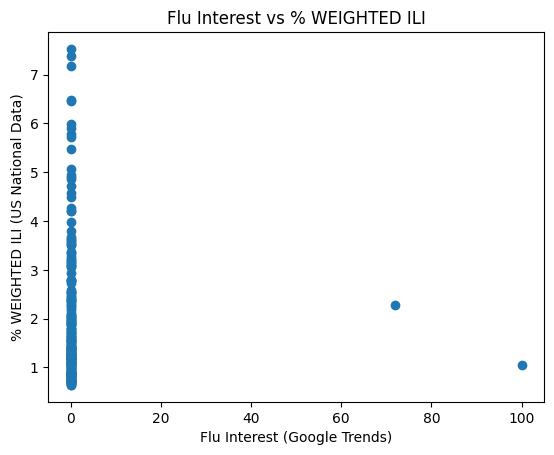

In [82]:
# Your Code goes here!

# Ensure flu_interest and ili_df['% WEIGHTED ILI'] are the same length and aligned by week
# flu_trends should be your DataFrame from pytrends.interest_over_time()
# Replace 'ID_Influenza' with the actual column name from flu_trends

# Example: If your keyword was 'influenza' or a topic id, use that as the column name
flu_interest = flu_trends.iloc[:, 0].reset_index(drop=True)  # first column is usually the interest
ili_aligned = ili_df['% WEIGHTED ILI'].reset_index(drop=True)

# Make sure both are the same length
min_len = min(len(flu_interest), len(ili_aligned))
flu_interest = flu_interest[:min_len]
ili_aligned = ili_aligned[:min_len]

plt.scatter(flu_interest, ili_aligned)
plt.xlabel('Flu Interest (Google Trends)')
plt.ylabel('% WEIGHTED ILI (US National Data)')
plt.title('Flu Interest vs % WEIGHTED ILI')
plt.show()



## 3.2 Measure Pearson’s correlation

In the following chunk, calculate Pearson’s correlation coefficient between `flu interest` and `% WEIGHTED ILI`.

For this you can use the [`pearsonr`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html) method of `scipy`.

In [83]:
# Your Code goes here!

corr_flu_ili, pval_flu_ili = stats.pearsonr(flu_interest, ili_aligned)
print(f"Pearson correlation coefficient: {corr_flu_ili:.4f}, p-value: {pval_flu_ili:.4g}")

Pearson correlation coefficient: -0.0301, p-value: 0.6654


## 3.3 Measure correlation after shuffling

What happens if we permute the data (e.g. shuffle the `flu interest`s) and repeat the above analysis? Do you find any difference between the two plots and two Pearson’s correlation coefficients?

For the shuffeling you can use `pandas` [`sample`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html) method with `frac` set to 1.

This test shows you if the correlation is happend by random.

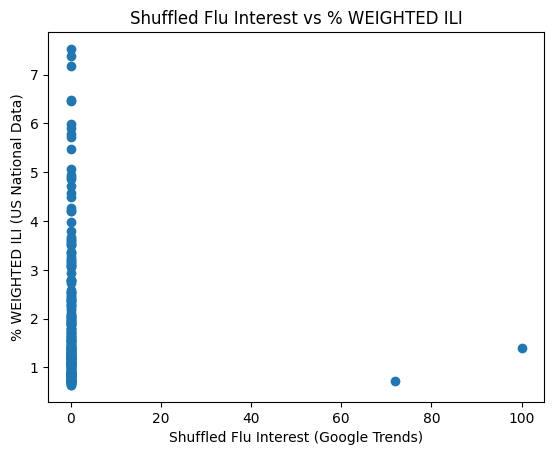

Shuffled Pearson correlation coefficient: -0.0604, p-value: 0.385


In [84]:
# Your Code goes here!

# Shuffle the flu_interest values
shuffled_flu_interest = flu_interest.sample(frac=1, random_state=42).reset_index(drop=True)

# Scatter plot of shuffled flu interest vs % WEIGHTED ILI
plt.scatter(shuffled_flu_interest, ili_aligned)
plt.xlabel('Shuffled Flu Interest (Google Trends)')
plt.ylabel('% WEIGHTED ILI (US National Data)')
plt.title('Shuffled Flu Interest vs % WEIGHTED ILI')
plt.show()

# Calculate Pearson correlation for shuffled data
shuffled_corr_flu_ili, shuffled_pval_flu_ili = stats.pearsonr(shuffled_flu_interest, ili_aligned)
print(f"Shuffled Pearson correlation coefficient: {shuffled_corr_flu_ili:.4f}, p-value: {shuffled_pval_flu_ili:.4g}")

Repeat the calculation with 1000 permutations and plot the histogram of the resulting values. Add a line with the value of the correlation without permutation. Is it far or close to the permuted values?

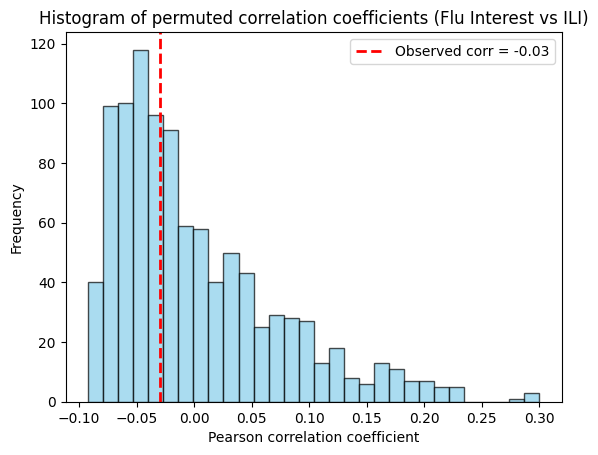

In [85]:
# Your Code goes here!

# Perform 1000 permutations and store the correlation coefficients
permuted_corrs_flu_ili = []

for _ in range(1000):
    shuffled_interest = flu_interest.sample(frac=1, replace=False).reset_index(drop=True)
    corr_perm, _ = stats.pearsonr(shuffled_interest, ili_aligned)
    permuted_corrs_flu_ili.append(corr_perm)

# Plot histogram of permuted correlations
plt.hist(permuted_corrs_flu_ili, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(corr_flu_ili, color='red', linestyle='dashed', linewidth=2, label=f'Observed corr = {corr_flu_ili:.2f}')
plt.xlabel('Pearson correlation coefficient')
plt.ylabel('Frequency')
plt.title('Histogram of permuted correlation coefficients (Flu Interest vs ILI)')
plt.legend()
plt.show()

### To learn more

#### Prediction
* Download the Google Trends data for 2019, and use your models to predict the values of `% WEIGHTED ILI`.
* Do the models make good predictions? Which model performs better?